## O. Importy a načítanie datasetu


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [2]:
#Import datasetu
dataset = pd.read_csv('Churn_Modelling.csv', index_col='RowNumber')
dataset.head()
data_train2 = dataset.drop(['CustomerId','Surname'],axis=1)

## 1. Príprava dát

In [3]:
# rozdelenie datasetu na dáta a hodnoty True/False (0,1), ktoré odkazujú na to 
# či zákazník opustil banku alebo nie.
X_col = dataset.columns.tolist()[2:12]
y_col = dataset.columns.tolist()[-1:]
print('Dáta', X_col)
print('True/False', y_col)

Dáta ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
True/False ['Exited']


In [4]:
# vytvorenie nummpy array z týchto stĺpcov
X = dataset[X_col].values 
y = dataset[y_col].values
X

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

Ako môžeme vidieť tak dáta obsahujú aj kategorické premenné, ktoré treba nahradiť.

In [5]:
encoder = LabelEncoder()
X[:,1] = encoder.fit_transform(X[:,1]) # zmena krajiny na hodnoty vhodné pre analýzu (0-France,1-Germany,2-France)
print('Krajina: ')
print(X[:,1])
X[:,2] = encoder.fit_transform(X[:,2]) # zmena pohlavia na hodnoty vhodné pre analýzu (0-Female, 1-Male)
print('Pohlavie: ')
print(X[:,2])

Krajina: 
[0 2 0 ... 0 1 0]
Pohlavie: 
[0 0 0 ... 0 1 0]


In [6]:
pipeline = Pipeline(
    [('Categorizer', ColumnTransformer(
         [
          ("Gender", OneHotEncoder(categories='auto', drop='first'), [2]),
           
          ("Geography", OneHotEncoder(categories='auto', drop='first'), [1])
         ], remainder='passthrough', n_jobs=1)),
     # Standard Scaler for the classifier
    ('Normalizer', StandardScaler())
    ])

In [7]:
X = pipeline.fit_transform(X)

In [8]:
# Rozdelenie datasetu na testovacie a trénovacie dáta v pomere 30:70
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0) 

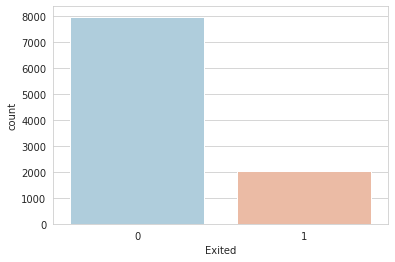

In [9]:
data2 = dataset.drop(['CustomerId','Surname'],axis=1)
sns.set_style('whitegrid')
sns.countplot(x='Exited',data=data2,palette='RdBu_r')
# je vidieť, že dáta nie sú veľmi vyvážené.

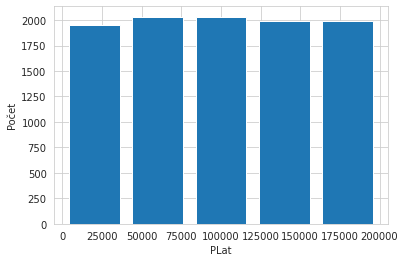

In [10]:
plt.hist(data2.EstimatedSalary, bins=5
         , rwidth=0.8)
plt.xlabel('PLat')
plt.ylabel('Počet')
plt.show()

##2. Vytvorenie NS

In [11]:
classifier = Sequential()

In [12]:
# Vstupná vrstva a prvá skrytá vrstva
classifier.add(Dense(6, activation = 'relu',input_shape = (X_train.shape[1], )))
# pridanie nasledujúcej skrytej vrstvy
classifier.add(Dense(6, activation = 'relu')) 
# pridatnie výstupnej vrstvy
classifier.add(Dense(1, activation = 'sigmoid')) 
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [13]:
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [14]:
trenovanie = classifier.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1, verbose=2)

Epoch 1/100
197/197 - 1s - loss: 0.6485 - accuracy: 0.6478 - val_loss: 0.5506 - val_accuracy: 0.7929
Epoch 2/100
197/197 - 0s - loss: 0.5166 - accuracy: 0.7946 - val_loss: 0.4787 - val_accuracy: 0.8014
Epoch 3/100
197/197 - 0s - loss: 0.4691 - accuracy: 0.7973 - val_loss: 0.4488 - val_accuracy: 0.8014
Epoch 4/100
197/197 - 0s - loss: 0.4475 - accuracy: 0.7973 - val_loss: 0.4364 - val_accuracy: 0.8014
Epoch 5/100
197/197 - 0s - loss: 0.4375 - accuracy: 0.7973 - val_loss: 0.4286 - val_accuracy: 0.8014
Epoch 6/100
197/197 - 0s - loss: 0.4322 - accuracy: 0.7981 - val_loss: 0.4238 - val_accuracy: 0.8014
Epoch 7/100
197/197 - 0s - loss: 0.4285 - accuracy: 0.7986 - val_loss: 0.4195 - val_accuracy: 0.8071
Epoch 8/100
197/197 - 0s - loss: 0.4250 - accuracy: 0.8013 - val_loss: 0.4159 - val_accuracy: 0.8086
Epoch 9/100
197/197 - 0s - loss: 0.4213 - accuracy: 0.8046 - val_loss: 0.4121 - val_accuracy: 0.8200
Epoch 10/100
197/197 - 0s - loss: 0.4166 - accuracy: 0.8135 - val_loss: 0.4064 - val_accura

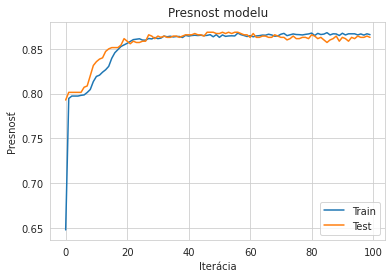

In [15]:
plt.plot(trenovanie.history['accuracy'])
plt.plot(trenovanie.history['val_accuracy'])
plt.ylabel('Presnosť')
plt.xlabel('Iterácia')
plt.title('Presnost modelu')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

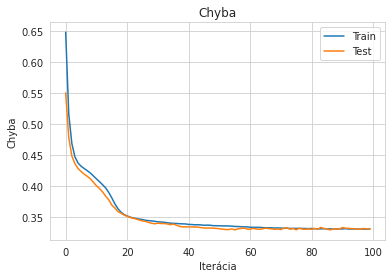

In [16]:
plt.plot(trenovanie.history['loss']) 
plt.plot(trenovanie.history['val_loss']) 
plt.ylabel('Chyba') 
plt.xlabel('Iterácia')
plt.title('Chyba') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()